In [ ]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def loading_data(filepath):
    #loading data
    ml = pd.read_csv(filepath, header=None)
    ml.columns = ['User','Item','ItemRating']
    return ml

In [ ]:
def create_interaction_cov(ml):
    # creating matrix from transactions
    ml_user_item_matrix = ml.pivot(index='User', columns='Item', values='ItemRating')
    ml_user_item_matrix = ml_user_item_matrix.fillna(0)
    ml_user_item_matrix = ml_user_item_matrix.reindex(index=range(ml_user_item_matrix.index.max() + 1), columns= range(ml_user_item_matrix.columns.max() + 1), fill_value=0)
    
    # create user covariance matrix
    cov_ml = np.dot(ml_user_item_matrix.values,ml_user_item_matrix.T.values)
    
    return ml_user_item_matrix, cov_ml

In [ ]:
def neighbors(cov_ml, user):
    # 'cov_ml' is the covariance matrix
    nn = np.argsort(-cov_ml[user,:])  # all neighbors sorted descending
    # I previously had a -1, double check
    return nn

In [ ]:
def prediction(ml_user_item_matrix, cov_ml, nn, user, item, number_of_n=10):
    neighbors = []
    
    # populating 'neighbors' with defined 'number_of_n'
    for n in nn:
        if len(neighbors) < number_of_n:
            if n in ml_user_item_matrix.index:
                # enforcing that neighbors have rated the item 
                if ml_user_item_matrix[item][n] != 0:
                    neighbors.append(n)

    # total weight of N neighbors
    total_distance = sum(cov_ml[user, neighbors])

    # get the proportion of weight for each neighbor
    weighted_input = cov_ml[user, neighbors] / total_distance

    # creating prediction from weighted average of neighbors ratings

    # getting the rating of the item to the predicted from each of the neighbors
    neighbors_ratings = []
    for e in neighbors:
        neighbors_ratings.append(ml_user_item_matrix[item][e])

    weighted_rate = neighbors_ratings * weighted_input
    prediction_rate = weighted_rate.sum()

    return weighted_input, neighbors_ratings, prediction_rate

### Load training set and Create interaction matrix

In [ ]:
ml2 = loading_data("data/ml1m-train-clean")
ml_user_item_matrix, cov_ml = create_interaction_cov(ml2)

In [ ]:
ml_user_item_matrix.shape, cov_ml.shape

> There are 6041 users and 3953 items
+ When we create a User covariance similarity matrix we end up with a 6041x6041 U/U matrix

In [ ]:
ml_user_item_matrix.head()

In [ ]:
# find neighbors of user "1"
u = 1
nn = neighbors(cov_ml, u)

In [ ]:
nn

In [ ]:
i = 2018

In [ ]:
# to make prediction for user ='1' and item '2018'
weighted_input, ratings_for_item, prediction_rate = prediction(ml_user_item_matrix, cov_ml, nn, u, i, number_of_n=10)

In [ ]:
prediction_rate

## Load validation set

In [ ]:
val = pd.read_csv("data/ml1m-validation-clean", header=None)
val.columns = ['User','Item','ItemRating']

In [ ]:
val.head()

## Make Predictions

To make predictions, we need to:
+ find the neighbors of user "u"
+ calculate a weighted average of the ratings of movie "i" for the neighbors of "u"

Lets calculate the neighbors for each of the users in the test/val set and add them to the dataframe

In [ ]:
val["Neighbors"] = val["User"].apply(lambda x: neighbors(cov_ml, x))

In [ ]:
val.head()

In [ ]:
users = val["User"].values
items = val["Item"].values
nn = val["Neighbors"].values

Lets test the prediction process through the first **5 items** in the test set, using **10 nearest neighbors**

In [ ]:
prediction_rates = []
for i in range(5):
    prediction_rates.append(prediction(ml_user_item_matrix, cov_ml, nn[i], users[i], items[i], number_of_n=10)[2])

In [ ]:
prediction_rates

In [ ]:
# Adding predictions to dataframe
pred200 = pd.Series(prediction_rates200)
val200['Prediction'] = pred200.values

## Calculate RMSE

The prediction loop was used for a range of neighbors. Each of the outputs added to a column named "Prediction" and the dataframe were pickled with the following names:
+ val200.pickle
+ val300.pickle
+ val400.pickle
+ val500.pickle
+ val600.pickle
+ val700.pickle
+ val800.pickle
+ val900.pickle
+ val1000.pickle

In [ ]:
def calculate_RMSE(pickle_path):
    # Load pickled file with "Prediction"
    nn = pd.read_pickle(pickle_path)
    # Calculate "Error" for each prediction
    nn["Error"] = (nn["ItemRating"] - nn["Prediction"])**2
    number_of_preds = nn.shape[0]
    # Root mean square error
    rmse = math.sqrt(nn["Error"].sum() / number_of_preds)
    return rmse

In [ ]:
rmse200 = calculate_RMSE("data/val200.pickle")

In [ ]:
rmse200

In [ ]:
rmse300 = calculate_RMSE("data/val300.pickle")
rmse400 = calculate_RMSE("data/val400.pickle")
rmse500 = calculate_RMSE("data/val500.pickle")
rmse600 = calculate_RMSE("data/val600.pickle")
rmse700 = calculate_RMSE("data/val700.pickle")
rmse800 = calculate_RMSE("data/val800.pickle")
rmse900 = calculate_RMSE("data/val900.pickle")
rmse1000 = calculate_RMSE("data/val1000.pickle")

In [ ]:
x = np.linspace(200, 1000, 9)

In [ ]:
x

In [ ]:
rmse_values = [rmse200, rmse300, rmse400, rmse500, rmse600, rmse700, rmse800, rmse900, rmse1000]

In [ ]:
data = { "neighbors": x, "COV-RMSE": rmse_values}

In [ ]:
data

In [ ]:
neighbors = pd.DataFrame(data = data, columns=["neighbors", "COV-RMSE"])

In [ ]:
neighbors.head()

In [ ]:
ax = neighbors.plot( x="neighbors",style=['rx'], figsize=(8,4));
ax.set_ylabel("RMSE");
ax.set_xlabel("Neighbors");
ax.set_title("Evaluation Scores");

## Comparing results

In [ ]:
l2v_exp = pd.read_pickle("data/l2v-neighbors.pickle")
l2v_neighbors = l2v_exp[["pred_neighbors","eval_score"]]
l2v_neighbors.columns = ["pred_neighbors","L2V-RMSE"]
l2v_neighbors.head()

In [ ]:
# adding COV-RMSE to dataframe containing l2V-RMSE
# l2v_neighbors.loc[l2v_neighbors.pred_neighbors == 200, "COV-RMSE"] = rmse200

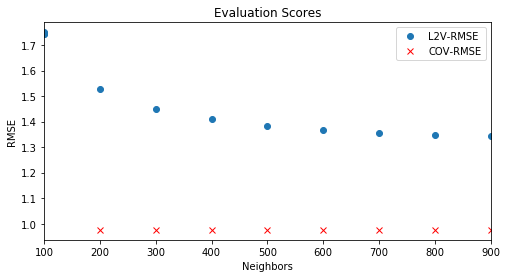

In [84]:
ax = l2v_neighbors.plot( x="pred_neighbors",style=['o','rx'], figsize=(8,4));
ax.set_ylabel("RMSE");
ax.set_xlabel("Neighbors");
ax.set_title("Evaluation Scores");

> The hyperparameters for L2v in the comparison are the experiments listed below (which can be found in "/CONFIG" folder in s3)

In [85]:
import sqlalchemy
import psycopg2

In [86]:
db_string = "postgresql://localhost:5433/jaimealmeida"
engine = sqlalchemy.create_engine(db_string)

In [92]:
the_frame = pd.read_sql_query("SELECT experimentid, pred_neighbors, eval_score  FROM %s WHERE pred_neighbors > 100 and pred_neighbors < 1100;" % "experiments", engine)

In [94]:
the_frame.sort_values(by="pred_neighbors")

,experimentid,pred_neighbors,eval_score
4,du05-d100w10l80n10d30-p5q1-200-072717,200,1.527724
1,du05-d100w10l80n10d30-p5q1-300-072717,300,1.449006
2,du05-d100w10l80n10d30-p5q1-400-072717,400,1.409381
3,du05-d100w10l80n10d30-p5q1-500-072717,500,1.383879
5,du05-d100w10l80n10d30-p5q1-600-072717,600,1.368604
6,du05-d100w10l80n10d30-p5q1-700-072717,700,1.356443
7,du05-d100w10l80n10d30-p5q1-800-072717,800,1.348276
8,du05-d100w10l80n10d30-p5q1-900-072717,900,1.342677
0,du05-d100w10l80n10d30-p5q1-1000-072717,1000,1.337528
